# STM Transit Delay Data Modeling

## Overview

This notebook explores three tree-based regression models in order to find the one that predicts the delay with the best accuracy.

## Data Description


`vehicle_id`: Unique identifier for a vehicle.<br>
`vehicle_lat`, `vehicle_lon`: Vehicle current position.<br>
`vehicle_distance`: Vehicle distance from the stop, in meters.<br>
`vehicle_status_Stopped At`: Indicates if the vehicle has stopped or if it is in transit.<br>
`vehicle_bearing`: Direction that the vehicle is facing.<br>
`vehicle_speed`: Momentary speed measured by the vehicle, in meters per second.<br>
`occupancy_status`: Degree of passenger occupancy, ranging from 1 (empty) to 7 (not accepting passengers).<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_sequence`: Sequence of a stop, for ordering.<br>
`trip_progress`: How far along the trip is the vehicle, from 0 to 100%.<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false.<br>
`month`, `day`, `hour`: Month, day of week and hour of the realtime arrival time.<br>
`sch_month`, `sch_day`, `sch_hour`: Month, day of week and hour of the scheduled arrival time.<br>
`is_weekend`: Indicates if the day of the arrival time is on the weekend.<br>
`is_peak_hour`: Indicates of the day and hour of the arrival time is at peak hour (weekdays between 7-9am and 4-6pm).<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`windspeed`: Wind speed at 10 meters above ground, in km/h.<br>
`weather_Light drizzle`, `weather_Mainly clear`, `weather_Overcast`,
`weather_Partly cloudy`: Indicates the weather category.<br>
`incident_nearby`: Indicates if an incident happened within 500 meters of the vehicle position.<br>
`delay`: Difference between real and scheduled arrival time, in seconds.

## Imports

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('../data/preprocessed.csv')

## Split the data

In [3]:
# Separate the features from the target variable
X = df.drop('delay', axis=1)
y = df['delay']

In [4]:
# Train-validation-test split (70-15-15) 
# Use 70% for training because the dataset is large
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Since only tree-based regression models are explored in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## First Model: Random Forest Regression

### Find optimal number of trees

In [5]:
# Initialize model with warm start to allow adding more trees without resetting
rf = RandomForestRegressor(
  n_estimators=20,
  warm_start=True,
  random_state=42,
  n_jobs=-1
)

In [6]:
# Combine warm start with manual early stopping
errors = []
n_estimators_range = range(20, 720, 20)
best_rmse = float('inf')
best_n = 20

for n in n_estimators_range:
    rf.n_estimators = n
    rf.fit(X_train, y_train)  # keep training, adding 20 more trees each time
    preds = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    errors.append(rmse)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_n = n

print(f'Best number of trees: {best_n} with RMSE: {best_rmse:.4f}')

Best number of trees: 680 with RMSE: 115.7836


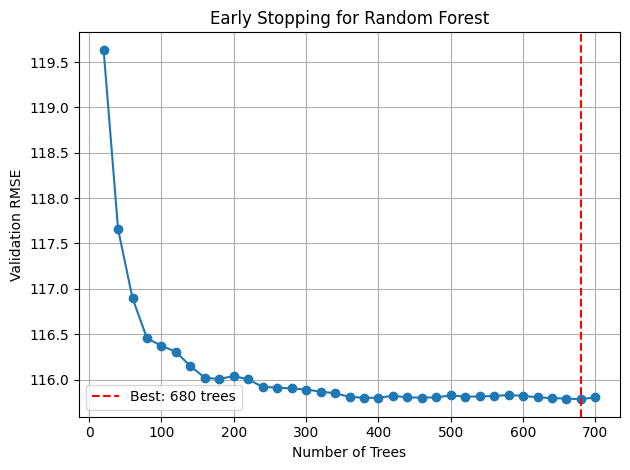

In [7]:
# Plot the RMSE curve
plt.plot(n_estimators_range, errors, marker='o')
plt.axvline(x=best_n, color='r', linestyle='--', label=f'Best: {best_n} trees')
plt.xlabel('Number of Trees')
plt.ylabel('Validation RMSE')
plt.title('Early Stopping for Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/early_stopping_rf.png')
plt.show()

### Fit Base Model

In [ ]:
# Use optimal number of trees
rf_base = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)

RandomForestRegressor(n_estimators=680, n_jobs=-1, random_state=42)

### Evaluate Model

#### Metrics

In [9]:
y_pred = rf_base.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Create dataframe to track metrics
metrics = [{'model': 'rf_base', 'params': rf_base.get_params(), 'MAE': mae, 'RMSE': rmse, 'R²': r2}]
metrics_df = pd.DataFrame(metrics)

In [10]:
metrics_df.loc[metrics_df['model'] == 'rf_base', ['MAE', 'RMSE', 'R²']].iloc[0]

MAE      69.913726
RMSE    115.783575
R²        0.272493
Name: 0, dtype: float64

**MAE**<br>
On average, the predictions are off by 70 seconds, which seems acceptable.

**RMSE**<br>
The typical error being less than 2 minutes seems pretty reasonable.

**R²**<br>
The model explains 27% of the variance in the actual delays, which is not very good, but understandable considering how noisy and random transit delays can be (weather, mechanical issues, accidents, etc.)

#### Residual Analysis

In [11]:
def plot_residuals(y_pred: pd.Series, y_true:pd.Series, model_name:str) -> None:
	fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

	# Predicted vs. actual values
	ax1.scatter(x=y_pred, y=y_true)
	ax1.set_title('Predicted vs. Actual values')
	ax1.set_xlabel('Predicted delay (seconds)')
	ax1.set_ylabel('Actual delay (seconds)')
	ax1.grid(True)

	# Residuals
	residuals = y_true - y_pred
	ax2.scatter(x=y_pred, y=residuals)
	ax2.set_title('Residual Plot')
	ax2.set_xlabel('Predicted Delay (seconds)')
	ax2.set_ylabel('Residuals (seconds)')
	ax2.axhline(0, linestyle='--', color='orange')
	ax2.grid(True)

	fig.suptitle('Residual Analysis', fontsize=18)
	fig.tight_layout()
	fig.savefig(f'../images/residual_analysis_{model_name}.png', bbox_inches='tight')
	plt.show()

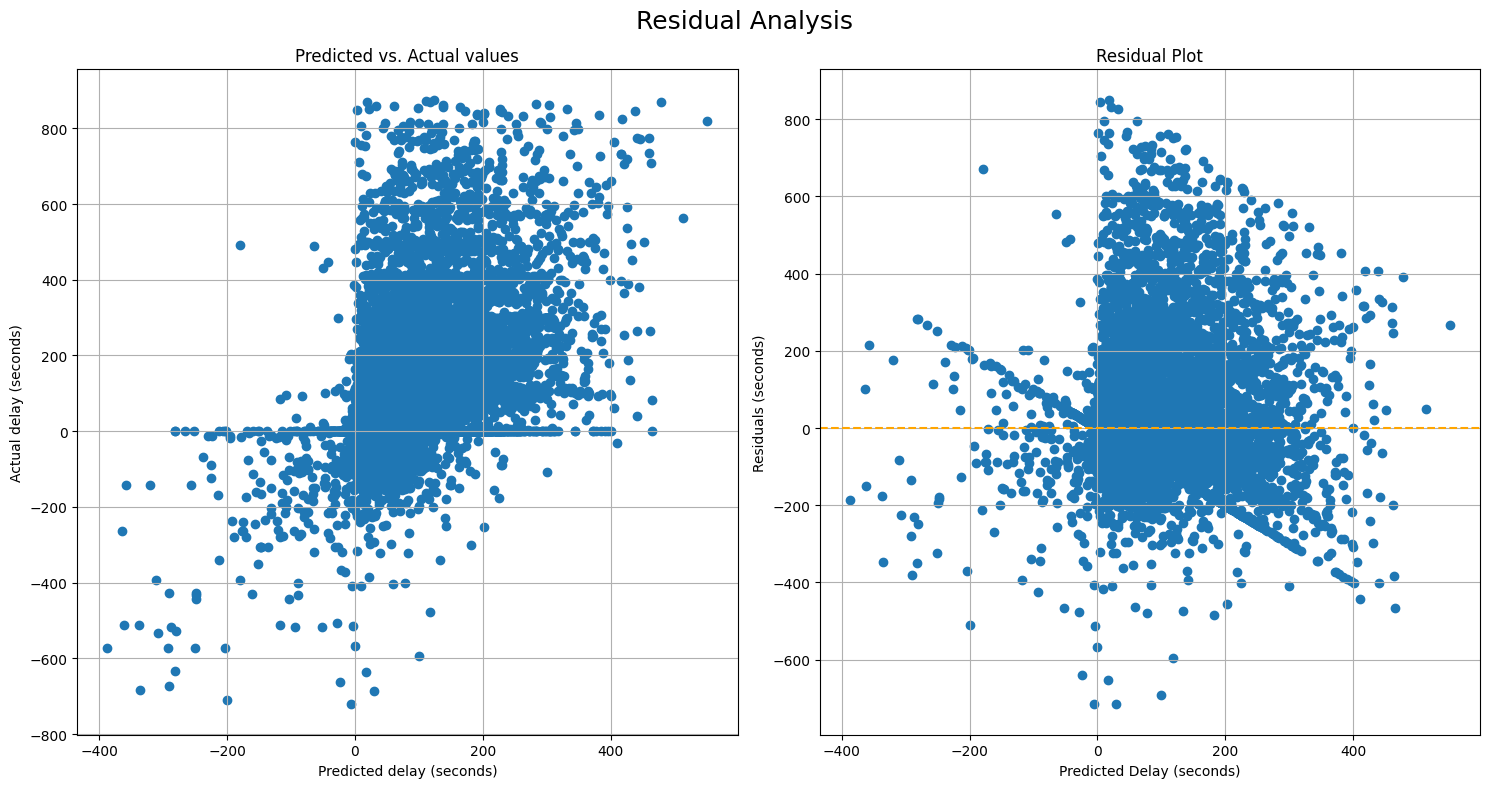

In [12]:
plot_residuals(y_pred, y_val, 'rf_base')

The predicted vs. actual plot shows a scatter of points, with some spread around the diagonal line, which indicates the model's predictions are not perfect but are reasonable. The spread of points suggests the model has a reasonable fit but doesn't handle extreme delays very well.

From the residual plot, it seems that the residuals are fairly spread out, with two visible funnel shape and most of the data clustered around 0, but also a significant spread both above and below the 0 line. This suggests there is no clear pattern in residuals (not biased in one direction). Also, it suggests the residuals appear to increase as the predicted delay increases, meaning the model prediction errors are larger for higher predicted delays (heteroscedasticity). This means the model is better at predicting small delays than large delays.

### Hyperparameter tuning

Due to the large volume of data, the Randomized Search will be run instead of a Grid Search. Also, it will be done manually with early stopping to save computation time, because there's no retraining from scratch each time.

In [ ]:
# Define grids to search
nb_combinations = 10
n_estimators_range = range(20, 720, 20) 
max_depth_options = [None, 10, 20]
max_features_options = ['sqrt', 'log2', 0.8]
min_samples_split_options = [2, 5, 10]
min_samples_leaf_options = [1, 2, 5]
max_leaf_nodes_options = [None, 50, 100]

best_rmse = float('inf')
best_params = {}
counter = 0
# Loop over all combinations and number of trees
for i in range(nb_combinations):
	max_depth = random.choice(max_depth_options)
	max_features = random.choice(max_features_options)
	min_samples_split = random.choice(min_samples_split_options)
	min_samples_leaf = random.choice(min_samples_leaf_options)
	max_leaf_nodes = random.choice(max_leaf_nodes_options)
	
	rf = RandomForestRegressor(
		warm_start=True,
		n_estimators=50,
		max_depth=max_depth,
		max_features=max_features,
		min_samples_split=min_samples_split,
		min_samples_leaf=min_samples_leaf,
		max_leaf_nodes=max_leaf_nodes,
		random_state=42,
		n_jobs=-1
	)

	errors = []
	
	for n in n_estimators_range:
		counter += 1
		rf.n_estimators = n
		print(f'Combination {counter} params: {rf.get_params()}')
		rf.fit(X_train, y_train)
		preds = rf.predict(X_val)
		rmse = root_mean_squared_error(y_val, preds)
		errors.append(rmse)
		
		# Update best RMSE if better
		if rmse < best_rmse:
			best_rmse = rmse
			best_params = {
				'n_estimators': n,
				'max_depth': max_depth,
				'max_features': max_features,
				'min_samples_split': min_samples_split,
				'min_samples_leaf': min_samples_leaf,
				'max_leaf_nodes': max_leaf_nodes
			}
	
	# Plot RMSE for each parameter combination
	plt.plot(n_estimators_range, errors, label=f'Combination {counter}')

In [ ]:
# Plot Final RMSE curve
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Hyperparameter Tuning with Early Stopping')
plt.legend()
plt.savefig('../images/hyperparameter_tuning_rf.png', bbox_inches='tight')
plt.show()

In [ ]:
print(f'Best parameters found: {best_params} with RMSE: {best_rmse:.4f}')

In [ ]:
# Randomized search with 5-Fold Cross Validation
param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
	'max_leaf_nodes': [None, 50, 100],
	'max_depth': [None, 10, 20],
  	'max_features': ['sqrt', 'log2', 0.8],
}

random_model = RandomizedSearchCV(
  estimator=RandomForestRegressor(n_estimators=best_n, random_state=42, n_jobs=-1),
  param_distributions=param_grid,
  scoring='neg_root_mean_squared_error',
  n_iter=10,
  cv=5,
  n_jobs=-1,
  random_state=42
)

random_model.fit(X_train, y_train)

In [ ]:
# Fit model with best parameters
best_params = random_model.best_params_

rf_tuned = RandomForestRegressor(
  	n_estimators=best_n,
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)

In [ ]:
# Evaluate model
y_pred = rf_tuned.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_df.loc[len(metrics_df)] = ['rf_tuned', rf_tuned.get_params(), mae, rmse, r2]

In [ ]:
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

Interpret results

### Feature Importances

In [ ]:
importances = rf_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tuned.estimators_], axis=0)

In [ ]:
# Sort predictors
feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances

In [ ]:
# Plot the impurity-based importance (MDI)
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.savefig('../images/mdi_rf_tuned.png', bbox_inches='tight')
plt.show()

Interpret plot

### Recursive Feature Elimination (RFE)

In [ ]:
rfe_list = []
X_current = X.copy()
X_train_current = X_train.copy()
X_val_current = X_val.copy()
best_rmse = float('inf')
best_features = X_train_current.columns.tolist()
patience = 2 # allow 2 RMSE increases before stopping
patience_counter = 0 

keep_going = True

while keep_going and len(X_current.columns) > 5: # keep at least 5 features
	# Fit model
	rf = RandomForestRegressor(
		n_estimators=best_n,
		min_samples_split=best_params['min_samples_split'],
  		min_samples_leaf=best_params['min_samples_leaf'],
  		max_leaf_nodes=best_params['max_leaf_nodes'],
  		max_depth=best_params['max_depth'],
  		max_features=best_params['max_features'],
		random_state=42,
		n_jobs=-1
	)

	nb_features = len(X_current.columns)
	rf.fit(X_train_current, y_train)

	# Predict and calculate RMSE
	y_pred = rf.predict(X_val_current)
	rmse = root_mean_squared_error(y_val, y_pred)

	rfe = {
		'nb_features': nb_features,
		'rmse': rmse
	}

	# Feature importances
	importances = pd.Series(rf.feature_importances_, index=X_current.columns)
	weakest_feature = importances.idxmin()

	if rmse <= best_rmse:
		best_rmse = rmse
		best_features = X_current.columns.tolist()
		
		# Drop the weakest feature
		print(f'RMSE: {rmse:.4f} | Dropping: {weakest_feature} (importance {importances.min():.6f})')
		X_current = X_current.drop(columns=[weakest_feature], axis=1)
		X_train_current = X_train_current.drop(columns=[weakest_feature], axis=1)
		X_val_current = X_val_current.drop(columns=[weakest_feature], axis=1)

		patience_counter = 0 # reset patience is RMSE improves
		rfe['worsened_point'] = False
		rfe_list.append(rfe)
	else:
		patience_counter += 1
		rfe['worsened_point'] = True
		rfe_list.append(rfe)
		print(f'Patience counter: {patience_counter}/{patience}')

		if patience_counter >= patience:
			print('Performance worsened too much. Stopping feature elimination.')
			keep_going = False
		else:
			# Allow two bad steps: still drop feature and continue
			X_current = X_current.drop(columns=[weakest_feature], axis=1)
			X_train_current = X_train_current.drop(columns=[weakest_feature], axis=1)
			X_val_current = X_val_current.drop(columns=[weakest_feature], axis=1)


rfe_df = pd.DataFrame(rfe_list)
print('\nBest set of features found:')
print('\n'.join(best_features))
print(f'Final validation RMSE: {best_rmse:.4f}')

In [ ]:
worsened_mask = rfe_df['worsened_point']

# Plot RSME at each step
plt.figure(figsize=(10,6))

# Good steps
plt.plot(
  rfe_df.loc[~worsened_mask, 'nb_features'],
  rfe_df.loc[~worsened_mask, 'rmse'],
  marker='o-',
  label='Improved or Same RMSE',
  color='blue')

# Worsened steps
plt.plot(
  rfe_df.loc[worsened_mask, 'nb_features'],
  rfe_df.loc[worsened_mask, 'rmse'],
  marker='X',
  label='Worsened RMSE',
  color='red')

plt.gca().invert_xaxis() # Highest number of features on the left
plt.xlabel('Number of Features')
plt.ylabel('Validation RMSE')
plt.title('Recursive Feature Elimination Progress')
plt.legend()
plt.grid(True)
plt.savefig('../images/rfe_rf_tuned.png', bbox_inches='tight')
plt.show()

In [ ]:
# Keep best features
X_best = X[best_features]
X_train_best = X_train[best_features]
X_val_best = X_val[best_features]

In [ ]:
# Retrain model on reduced features
rf_retrained = RandomForestRegressor(
  	n_estimators=best_n,
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

rf_retrained.fit(X_train_best, y_train)

In [ ]:
# Evaluate model
y_pred = rf_retrained.predict(X_val_best)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_df.loc[len(metrics_df)] = ['rf_retrained', rf_retrained.get_params(), mae, rmse, r2]

In [ ]:
metrics_df[['MAE', 'RMSE', 'R²']]

### Retune Parameters

In [ ]:
param_grid = {
	'n_estimators': list(range(300, 750, 50)),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
	'max_leaf_nodes': [None, 50, 100],
	'max_depth': [None, 10, 20],
  	'max_features': ['sqrt', 'log2', 0.8],
}

random_model = RandomizedSearchCV(
  	estimator=RandomForestRegressor(random_state=42),
  	param_distributions=param_grid,
  	scoring='neg_root_mean_squared_error',
  	n_iter=10,
	cv=5,
  	n_jobs=-1,
  	random_state=42
)

random_model.fit(X_train_best, y_train)

In [ ]:
# Fit model with best parameters
best_params = random_model.best_params_

rf_final = RandomForestRegressor(
  	n_estimators=best_params['n_estimators'],
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train_best, y_train)

### Revalidate Model

In [ ]:
# Evaluate model
y_pred = rf_final.predict(X_val_best)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_df.loc[len(metrics_df)] = ['rf_final', rf_final.get_params(), mae, rmse, r2]

In [ ]:
metrics_df[['MAE', 'RMSE', 'R²']]

Interpret results

In [ ]:
# Plot predicted vs. actual values
plt.scatter(x=y_pred, y=y_val)
plt.title('Final Model Predicted vs. Actual values')
plt.xlabel('Predicted delay (seconds)')
plt.ylabel('Actual delay (seconds)')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/actual_vs_predict_rf_final.png', bbox_inches='tight')
plt.show()

Interpret plot

In [ ]:
# Plot residuals
residuals = y_val - y_pred
    
plt.scatter(x=y_pred, y=residuals)
plt.title('Final Model Residual Plot')
plt.xlabel('Predicted Delay (seconds)')
plt.ylabel('Residuals (seconds)')
plt.axhline(0, linestyle='--', color='orange')
plt.tight_layout()
plt.savefig('../images/residual_plot_rf_final.png', bbox_inches='tight')
plt.show()

Interpret plot

In [ ]:
# Save best parameters and features
rf_attributes = {
	'best_params': best_params,
  	'best_features': best_features,
}

with open('../models/rf_attributes.pkl', 'wb') as handle:
	pickle.dump(rf_attributes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Save model
joblib.dump(rf_final, '../models/rf_model.pkl')

## Second Model: Random Forest + Gradient Boosting (Model ensembling)

## Third Model: XGBoost

## Final Model

### Evaluation

### Make Prediction

## End